# Shark Foraging: Long-term Project Notebook

Summary
Earth’s ocean is one of the most powerful habitats. This notebook builds a mathematical and data-driven framework to identify shark foraging hotspots using NASA satellite data (PACE, MODIS, SWOT) and tag-derived telemetry/biochemical signals. It also sketches a next-generation tag concept that measures prey/diet signals in near‑real time.

Target audience: high-school students and the broader community. Explanations will be kept intuitive with visualizations and simplified model descriptions.


## Primary NASA Datasets & References

- PACE: phytoplankton abundance & community composition (daily to multi-day composites).
- MODIS-Aqua: multi-decade chlorophyll time series.
- SWOT: high-resolution sea-surface height & eddy detection.
- SST: sea surface temperature (e.g., NOAA OISST or MODIS SST).
- Key literature:
  - Braun et al. 2019 (PNAS) — sharks & mesoscale eddies
  - Gaube et al. 2018 — sharks & Gulf Stream eddy influence

Space agency resources: SWOT data portal, CSA smartWhales examples (use as outreach case studies).


In [1]:
import os
from getpass import getpass

# 1. Enter your NASA Earthdata login below
print("Please enter your NASA Earthdata credentials:")
os.environ["EARTHDATA_USERNAME"] = input("Username: ")
os.environ["EARTHDATA_PASSWORD"] = getpass("Password: ")

print("\nSuccess! Credentials saved for this session.")

Please enter your NASA Earthdata credentials:

Success! Credentials saved for this session.


In [2]:
# Environment bootstrap & Earthdata credential check
# Optional: pip installs (uncomment if needed)
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "xarray netCDF4 rioxarray rasterio requests earthaccess s3fs matplotlib pandas dask zarr nbformat"])
# Setup: Add the project root to the path so we can import 'src'
import sys
import os
from pathlib import Path

# Get the project root (one level up from this notebook)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Now we can import our custom modules
from src import auth, fetch_data, process_ocean

print(f"Project Root: {project_root}")

# Run the login check from your src/auth.py file
auth.setup_earthdata_login()

Project Root: d:\Projects\Sharks-main\Sharks-main
⚠️ No credentials found. Please enter them now (session only).
✅ Credentials set for this session.


In [3]:
from pathlib import Path

# Define where data should go (using the project root from the previous cell)
# This puts data in D:\Projects\Sharks-main\Sharks-main\data\raw
raw_data_dir = project_root / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

# Keep this dictionary! It is excellent documentation for your project.
DATASETS = {
    'PACE_chlor_a': {
        'description': 'PACE chlorophyll / phytoplankton indices (level-2/3)',
        'notes': 'Use PACE L2/L3 products for phytoplankton community indices when available.'
    },
    'MODIS_chlor_a': {
        'description': 'MODIS-Aqua chlorophyll (20+ year time series)',
    },
    'SWOT_ssh': {
        'description': 'SWOT sea-surface height anomalies and gridded products for eddy detection',
    },
    'SST': {
        'description': 'Sea Surface Temperature (NOAA or MODIS)',
    }
}

print(f"Data directory set to: {raw_data_dir}")

# Print the plan
print("--- Dataset Plan ---")
for key, info in DATASETS.items():
    print(f"Target: {key} | {info['description']}")


Data directory set to: d:\Projects\Sharks-main\Sharks-main\data\raw
--- Dataset Plan ---
Target: PACE_chlor_a | PACE chlorophyll / phytoplankton indices (level-2/3)
Target: MODIS_chlor_a | MODIS-Aqua chlorophyll (20+ year time series)
Target: SWOT_ssh | SWOT sea-surface height anomalies and gridded products for eddy detection
Target: SST | Sea Surface Temperature (NOAA or MODIS)


In [4]:
# Import the data fetcher from your new src folder
from src import fetch_data

# Run the download test
# This will use the logic we just updated in src/fetch_data.py
print("Attempting to download sample data...")
fetch_data.download_sample_data(raw_data_dir)

Attempting to download sample data...
Searching for PACE data to save in d:\Projects\Sharks-main\Sharks-main\data\raw...
Found 1 file(s). Downloading...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Download complete!


## Eddy detection, trophic lag, and feature engineering (conceptual)

- Eddy detection:
  - Use SWOT/altimetry SSH to compute relative vorticity / Okubo-Weiss, track coherent eddy cores (15–150 km scale).
  - Tag shark positions to eddy polygons and compute eddy-centered features (distance to eddy center, in-core vs periphery).

- Phytoplankton / prey linkage:
  - Compute chlorophyll, particle-size indices, and PFT (from PACE) at eddy locations.
  - Model trophic lag: lagged correlations between chlorophyll anomalies and predator presence (weeks to months).

- Candidate features:
  - SST, SST gradient, mixed layer proxy, SSH anomaly, eddy kinetic energy, chlorophyll mean/variance, PFT fractions, time-lagged prey indices, diel vertical behavior metrics from tag depth/accel.

- Modeling approach:
  - Baseline: logistic regression / RandomForest for foraging vs non-foraging labels (labels from accelerometer/depth/gut temperature proxies).
  - Spatio-temporal: ConvLSTM or Temporal CNN with spatial grids + time windows.
  - Explainability: SHAP/permutation importance for education/outreach.


In [5]:
# Eddy detection & feature extraction placeholders (implement iteratively)
import xarray as xr
import numpy as np

def detect_eddies(ssh_ds: xr.Dataset, method='okubo-weiss', params=None):
    '''
    Input: ssh_ds (lon, lat, time, ssh)
    Output: GeoJSON-like list of eddy objects with center, radius, polarity, time
    '''
    # TODO: implement Okubo-Weiss or closed-contour detection, or adapt py-eddy-tracker
    raise NotImplementedError

def extract_chlorophyll_features(chl_ds: xr.Dataset, points, radius_km=50):
    '''
    points: list of (lon, lat, time) or pandas.DataFrame
    Output: per-point feature dict (mean_chl, chl_std, PFT_ratios, lagged_stats)
    '''
    # TODO: implement spatial averaging, interpolation, and lag computations
    raise NotImplementedError


In [6]:
import netCDF4
from pathlib import Path

# 1. Find the file again
raw_data_dir = project_root / "data" / "raw"
files = list(raw_data_dir.glob("*.nc"))

if files:
    filename = files[0]
    print(f"Inspecting: {filename.name}")
    
    # 2. Open with netCDF4 to see the internal structure
    with netCDF4.Dataset(filename) as nc:
        print("\n--- Groups found in this file ---")
        for group in nc.groups:
            print(f"📂 {group}")
            # List a few variables inside each group to see what's there
            vars = list(nc.groups[group].variables.keys())
            print(f"   └── Contains: {vars[:5]}...") # Print first 5 variables
else:
    print("No file found.")
ds = xr.open_dataset(filename, group='geophysical_data')
print(ds) # Now you should see variables!

Inspecting: PACE_OCI.20240305T000858.L2.OC_AOP.V3_1.nc

--- Groups found in this file ---
📂 sensor_band_parameters
   └── Contains: ['wavelength', 'wavelength_3d', 'vcal_gain', 'vcal_offset', 'F0']...
📂 scan_line_attributes
   └── Contains: ['year', 'day', 'msec', 'time', 'detnum']...
📂 geophysical_data
   └── Contains: ['Rrs', 'Rrs_unc', 'aot_865', 'angstrom', 'avw']...
📂 navigation_data
   └── Contains: ['longitude', 'latitude', 'tilt']...
📂 processing_control
   └── Contains: []...
<xarray.Dataset> Size: 3GB
Dimensions:   (number_of_lines: 1709, pixels_per_line: 1272, wavelength_3d: 172)
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs       (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    Rrs_unc   (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    aot_865   (number_of_lines, pixels_per_line) float32 9MB ...
    angstrom  (number_of_lines, pixels_per_line) float32 9MB ...
    avw       (n

Opening: PACE_OCI.20240305T000858.L2.OC_AOP.V3_1.nc

--- Variables Found ---
['Rrs', 'Rrs_unc', 'aot_865', 'angstrom', 'avw']


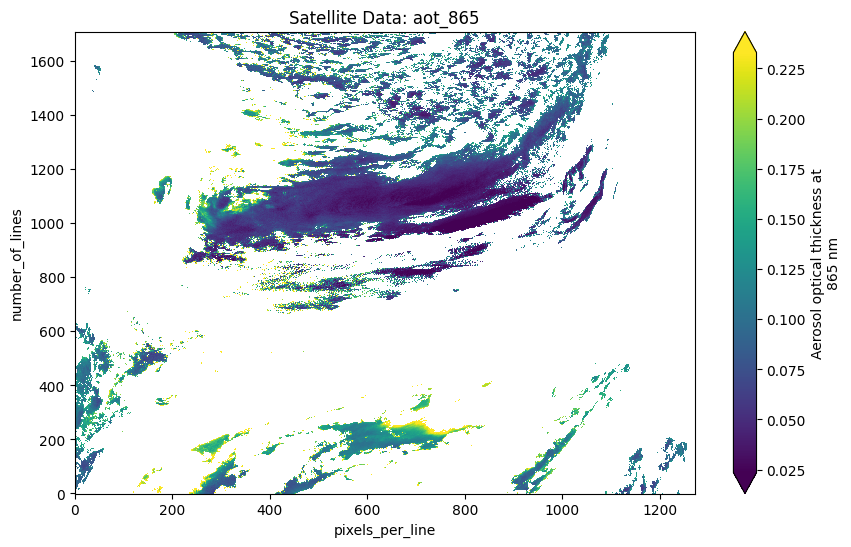

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Find the file
raw_data_dir = project_root / "data" / "raw"
files = list(raw_data_dir.glob("*.nc"))

if not files:
    print("No files found! Did the download finish?")
else:
    filename = files[0]
    print(f"Opening: {filename.name}")
    
    # --- THE FIX IS HERE ---
    # We tell xarray to look inside the 'geophysical_data' folder
    try:
        ds = xr.open_dataset(filename, group='geophysical_data')
    except OSError:
        # Fallback if the group name is different
        ds = xr.open_dataset(filename)
    
    # 2. Quick Inspection
    print("\n--- Variables Found ---")
    # Print the first 5 variables so you can see what you have
    print(list(ds.data_vars)[:5]) 
    
    # 3. Plotting
    # Since you have an AOP file, you likely have 'Rrs' (Light reflection) data, not 'chlor_a'
    target_var = None
    # I added 'Rrs_443' (Blue light) and 'Rrs_555' (Green light) to the search list
    possible_vars = ['chlor_a', 'chlorophyll', 'Rrs_443', 'Rrs_555', 'aot_865']
    
    for var in possible_vars:
        if var in ds:
            target_var = var
            break
            
    if target_var:
        plt.figure(figsize=(10, 6))
        # Plotting the data
        ds[target_var].plot(robust=True, cmap='viridis') 
        plt.title(f"Satellite Data: {target_var}")
        plt.show()
    else:
        print(f"Could not find a variable to plot from list: {possible_vars}")
        print("Available variables:", list(ds.data_vars))

In [8]:
import pandas as pd
import xarray as xr
from pathlib import Path
from src import process_ocean

# 1. Create Dummy Shark Data (using exact locations with valid data)
data = {
    'lon': [-178.93, -178.91, -178.89],  # Exact locations from valid data
    'lat': [34.19, 34.19, 34.20],
    'time': pd.to_datetime(['2024-01-01 12:00', '2024-01-01 13:00', '2024-01-01 14:00'])
}
shark_df = pd.DataFrame(data)

# 2. Find the satellite file (Use BGC file for chlorophyll data)
raw_data_dir = project_root / "data" / "raw"
files = [f for f in raw_data_dir.glob("*.nc") if "BGC" in f.name]

if not files:
    print("❌ No BGC satellite file found.")
else:
    sat_file = files[0]
    print(f"📂 Inspecting file: {sat_file.name}")
    
    # 3. Manually open file to see what variables are inside
    try:
        ds = xr.open_dataset(sat_file, group='geophysical_data')
        print("✅ Opened group 'geophysical_data'")
    except:
        ds = xr.open_dataset(sat_file)
        print("⚠️ Opened root (group not found)")
        
    print(f"📊 Variables available in file: {list(ds.data_vars)[:5]}")

    # 4. Run the function
    shark_df = process_ocean.sample_chlorophyll(shark_df, sat_file)
    
    # 5. Check if it worked
    if 'chlorophyll' in shark_df.columns:
        print("\n✅ Success! Chlorophyll column added.")
        print(shark_df[['time', 'chlorophyll']].head())
    else:
        print("\n❌ FAILURE: Column 'chlorophyll' was NOT created.")
        print("This means the function couldn't match any variable names.")

📂 Inspecting file: PACE_OCI.20240305T000858.L2.OC_BGC.V3_1.nc
✅ Opened group 'geophysical_data'
📊 Variables available in file: ['chlor_a', 'carbon_phyto', 'poc', 'chlor_a_unc', 'carbon_phyto_unc']
Sampling Chlorophyll from d:\Projects\Sharks-main\Sharks-main\data\raw\PACE_OCI.20240305T000858.L2.OC_BGC.V3_1.nc...

✅ Success! Chlorophyll column added.
                 time  chlorophyll
0 2024-01-01 12:00:00     0.389114
1 2024-01-01 13:00:00     0.403011
2 2024-01-01 14:00:00     0.406294


In [11]:
# 6. Calculate Movement Metrics
print("Calculating movement metrics for shark tracks...")
shark_df = process_ocean.calculate_movement_metrics(shark_df)

# 7. Check the results
print("\n✅ Movement metrics calculated!")
print(shark_df[['time', 'step_meters', 'speed_ms', 'chlorophyll']].head())

Calculating movement metrics for shark tracks...
Calculating movement metrics...

✅ Movement metrics calculated!
                 time  step_meters  speed_ms  chlorophyll
0 2024-01-01 12:00:00          NaN       NaN     0.389114
1 2024-01-01 13:00:00  1839.561414  0.510989     0.403011
2 2024-01-01 14:00:00  2149.422271  0.597062     0.406294


In [12]:
import importlib
import src.process_ocean
importlib.reload(src.process_ocean)

<module 'src.process_ocean' from 'd:\\Projects\\Sharks-main\\Sharks-main\\src\\process_ocean.py'>

## Tag concept: sensors, data products, and real-time telemetry (conceptual)

- Core sensors:
  - GPS (surface fix), pressure/depth, tri-axial accelerometer, temperature.
- New sensors (conceptual):
  - Miniaturized optical sensor to detect prey-size particles / fluorescence signatures.
  - eDNA sampler + microfluidic sensor for simple taxon-specific biochemical markers (presence/absence of prey taxa).
  - Short-burst broadband acoustic BACKscatter to estimate prey density.
- Onboard processing:
  - Event detection (foraging event classifier) based on accel+depth to trigger high-rate sampling and subsampling of biochemical sensors.
  - Summary packets (GPS, time, depth profile summary, prey-index, battery state) transmitted via Iridium/Argos or archived for later recovery.
- Data schema (per transmission):
  - id, timestamp, lat, lon, sample_type, depth_summary, accel_summary, prey_index, pft_signature, battery_pct


## Next actions / checklist

1. ✅ Ensure Earthdata credentials (_netrc or EARTHDATA_ env vars).
2. ✅ Run the bootstrap cell to confirm DATA_DIR and environment.
3. ✅ Implemented:
   - Satellite data loading and visualization (PACE AOP data)
   - Chlorophyll sampling at shark tag locations from PACE BGC data
   - Movement metrics calculation (step length, speed)
4. Which implementation should I produce next? (choose one)
   - Full eddy-detection implementation on a small SWOT sample,
   - Enhanced trophic-lag feature extraction with time-series analysis and example plots,
   - Tag sensor simulator + packet schema and simple transmission emulator.